# Portfolio Style Analysis
Analyze monthly portfolio returns using William Sharpe's style analysis technique. 

### Portfolio Returns
Load a .csv file of portfolio returns. Two columns (date and return) are expected, with a header row. Returns are expected in decimal format.

In [308]:
import pandas as pd
monthly_returns = pd.read_csv('returns.csv', parse_dates=[0], index_col=[0])

### Specify Bechmark Returns
S&P indicies are used to represent the styles. Depending on the next steps, it may be necessary to comment some of these indicies out due to high multi-colinearity. More styles indicies can be added to dictionary by finding the index name from the S&P website located [here](https://www.spglobal.com/spdji/en/).

In order to retrieve the index number, use the export tool for selected index data with the browser code inspector open on the 'network tab'. Monitor the get request url for the *indexId=* tag as the excel file download occur. 

Any colloquial name can be specified in the dictionary.

In [440]:
base_url = "https://www.spglobal.com/spdji/en/idsexport/file.xls?hostIdentifier=48190c8c-42c4-46af-8d1a-0cd5db894797&redesignExport=true&selectedModule=PerformanceGraphView&selectedSubModule=Graph&yearFlag=tenYearFlag&indexId="
indicies = {
    '92288997'  : 'S&P Global Developed Aggregate Ex-Collateralized Bond Index (USD)',
    '91922316'  : 'S&P U.S. Aggregate Bond Index',
    '92024521'  : 'S&P Canada Aggregate Bond Index',
    '5457924'   : 'S&P Developed BMI',
    '1639'      : 'S&P Composite 1500 Pure Growth',
    '1641'      : 'S&P Composite 1500 Pure Value',
    #'2762'      : 'S&P United States TMI', #
    '5457755'   : 'S&P/TSX Composite Index',
    '5457901'   : 'S&P Emerging BMI',
    '2239'      : 'S&P SmallCap 600',
     #'340'       : 'S&P 500', #
    '5475701'   : 'S&P Global Natural Resources Index',
    '5475707'   : 'S&P Global Oil Index',
    '5475848'   : 'S&P Global Timber & Forestry Index',
    '5475287'   : 'S&P Global Agribusiness Index',
    '100017558' : 'Dow Jones Precious Metals Index',
    '5534850'   : 'S&P Latin America BMI',
    '949444'    : 'S&P Europe SmallCap',
    '345444'    : 'S&P Eurozone BMI',
    '99105'     : 'S&P Asia Pacific BMI',
    '5537432'   : 'S&P Emerging Middle East & Africa BMI',
    '93979'     : 'S&P Pan Arab Investable',
    '2315363'   : 'S&P Pan Africa BMI',
    '92380776'  : 'S&P 500 Growth Value Rotator Index',
    '92289839'  : 'S&P Economic Cycle Factor Rotator Index',
    '92364852'  : 'S&P 500 High Momentum Value Sector Rotation',
    '92333068'  : 'S&P 500 VIX Front Month Futures Inverse Index',
    '11001395'  : 'S&P 500 Dynamic VIX Futures Index',
    '1692178'   : 'S&P Global Dividend Aristocrats',
    #'92353657'  : 'S&P Risk Parity Index - 15% Target Volatility', #
    '92353654'  : 'S&P Risk Parity Index - 10% Target Volatility' #
}
df = pd.DataFrame()
for key, value in indicies.items():
    url = base_url + str(key)
    idx_data = pd.read_excel(url, skiprows=6).dropna()
    idx_data.columns = ['date', value]
    idx_data['date'] = pd.to_datetime(idx_data['date'])
    idx_data.set_index('date', inplace=True)
    df = pd.concat([df, idx_data], join='outer', axis=1)    

### Resample
S&P provides daily data for 10 years. Resample to monthly data for style analysis.

In [441]:
df = df.fillna(method='ffill').resample('M').last()
df = df.dropna().pct_change()
df = df[df.index.isin(monthly_returns.index)]

### Inspect for Multi-Colinearity
Strong multi-colinearity between independent variables in the style regression can cause the condition number of the regression to be too large. The condition number represents the sensitivity of the model's output values for small changes in the inputs. The larget the number, the more sensitive and thus small errors in the input can greatly affect the output of the model.

In an attempt to reduce the condition number of the model in order to make it 'well-conditioned', you can examine the variance inflation factors and remove high VIF benchmark components from the style analysis. Some discretion is required here, at the end of day some economic intuition can help determine which indicies should belong in the regression. This is more of a tool to catch any obvious issues here

In [443]:
VIF_TOL = 200
from statsmodels.stats.outliers_influence import variance_inflation_factor 
X = df
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

,feature,VIF
0,S&P Global Developed Aggregate Ex-Collateraliz...,10.470520
1,S&P U.S. Aggregate Bond Index,12.167890
2,S&P Canada Aggregate Bond Index,8.208857
3,S&P Developed BMI,252.966418
4,S&P Composite 1500 Pure Growth,66.009384
5,S&P Composite 1500 Pure Value,43.613089
6,S&P/TSX Composite Index,22.939420
7,S&P Emerging BMI,13.632188
8,S&P SmallCap 600,70.135243
9,S&P Global Natural Resources Index,52.290003


### Style Analysis
Perform the regression, view all results. Formulas are dervied from [minitab docs](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/multiple-regression/methods-and-formulas/methods-and-formulas/).

In [498]:
from scipy.optimize import minimize
from IPython.display import display

X = df.to_numpy()
Y = monthly_returns.to_numpy()

# Define the Model
model = lambda b, X: np.sum(b * X, axis=1)

# The objective Function to minimize (least-squares regression)
obj = lambda b, Y, X: np.sum(np.power(Y.T - model(b, X), 2))

# Bounds: b[0..N] >= 0
bnds = [(0, None)] * len(df.columns)

# Constraint: sum(b) - 1 = 0
cons = [{'type': 'eq', 'fun': lambda b: np.sum(b) - 1}]

# Initial guess for b[1...N]:
xinit = np.array([0] * len(df.columns))

# options
opts = {'maxiter': 10000}

result = minimize(obj, x0=xinit, args=(Y, X), bounds=bnds, constraints=cons, method='SLSQP', tol=1e-10, options=opts)
coeff = result.x

n = Y.shape[0] # number of observations
k = X.shape[1] # number of terms

mse = np.sum(np.power(Y.T - np.sum(coeff * X, axis=1), 2)) / n
std_err = np.sqrt((np.linalg.inv(np.matmul(X.T, X)) * mse).diagonal())

summary = pd.DataFrame(coeff, columns=['coeff'], index=df.columns)
summary['std err'] = std_err
summary['t'] = np.round(summary['coeff'] / summary['std err'], decimals=5)
rsq_adj = 1 - np.sum(np.power(Y.T - np.sum(coeff * X, axis=1), 2)) / np.sum(np.power(Y.T - np.mean(Y), 2)) * ((n - 1)/(n - 2 - k))

# cleanup near-zero coeff
summary['coeff'] = summary['coeff'].apply(np.round, decimals=5)


print(f'Adjusted R-Squared {rsq_adj:.4f}')
display(summary)

Adjusted R-Squared 0.9114


,coeff,std err,t
S&P Global Developed Aggregate Ex-Collateralized Bond Index (USD),0.00000,0.112256,0.00000
S&P U.S. Aggregate Bond Index,0.00000,0.182637,0.00000
S&P Canada Aggregate Bond Index,0.54007,0.118651,4.55175
S&P Developed BMI,0.00000,0.178511,0.00000
S&P Composite 1500 Pure Growth,0.00000,0.066473,0.00000
S&P Composite 1500 Pure Value,0.00000,0.040881,0.00000
S&P/TSX Composite Index,0.12951,0.059713,2.16894
S&P Emerging BMI,0.01196,0.037513,0.31892
S&P SmallCap 600,0.07300,0.066773,1.09327
S&P Global Natural Resources Index,0.00000,0.064373,0.00000


## Results
Display the styles which represent the portfolio best. 

You can specify a custom critical T-Stat here if you prefer, just update CUSTOM_T_CRIT to a numerical value other than None.
The significance level (alpha) can also be set.

In [509]:
CUSTOM_T_CRIT = None
ALPHA = 0.05 # signficance level
from scipy import stats
dof = n - k
t_crit = stats.t.ppf(1 - ALPHA / 2, dof) if CUSTOM_T_CRIT is None else CUSTOM_T_CRIT
print(f't-crit: {t_crit:5f}, alpha: {ALPHA:.4f}')

sig_res = summary[abs(summary['t']) >= t_crit].copy()
sig_res['weight'] = sig_res['coeff'] / np.sum(sig_res['coeff'])
sig_res

t-crit: 2.068658, alpha: 0.0500


,coeff,std err,t,weight
S&P Canada Aggregate Bond Index,0.54007,0.118651,4.55175,0.80658
S&P/TSX Composite Index,0.12951,0.059713,2.16894,0.19342


### Bogey Formation

Based on the signficant results, a weighted bogey can be constructed for comparison to the actual portfolio. 

In [534]:
bogey = np.sum(df[list(sig_res.index)].to_numpy() * sig_res['weight'].to_numpy(), axis=1)
bogey = pd.DataFrame(bogey, index=df.index, columns=['return'])

### Performance Evaluation

Generate a tearsheet to assess the portfolio performance relative to the bogey in a more numerical manner

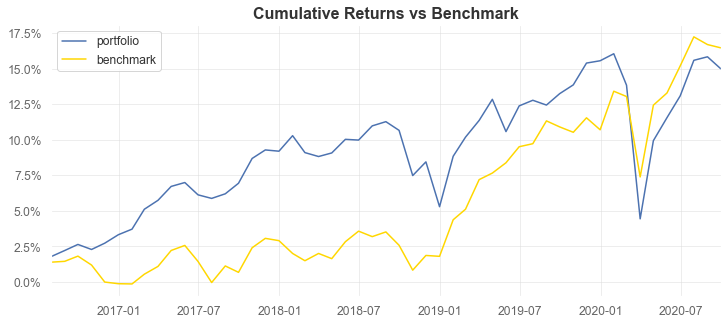

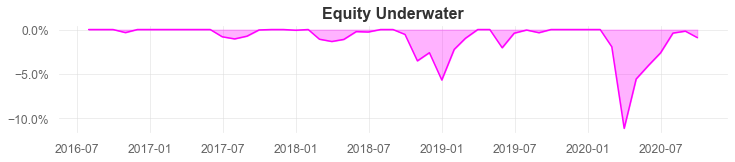

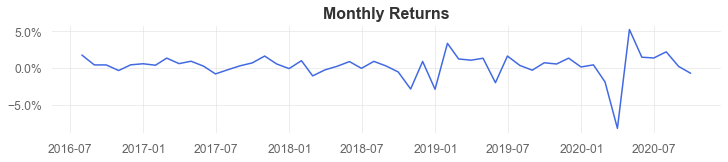

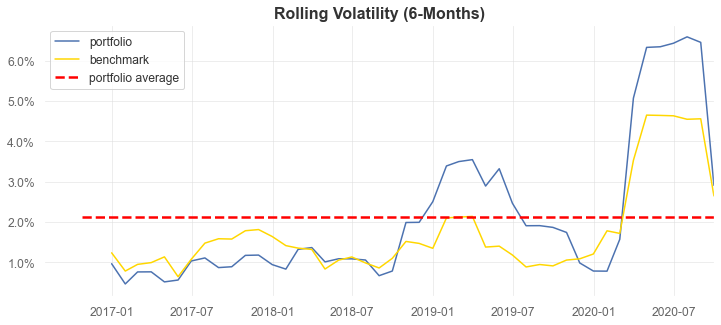

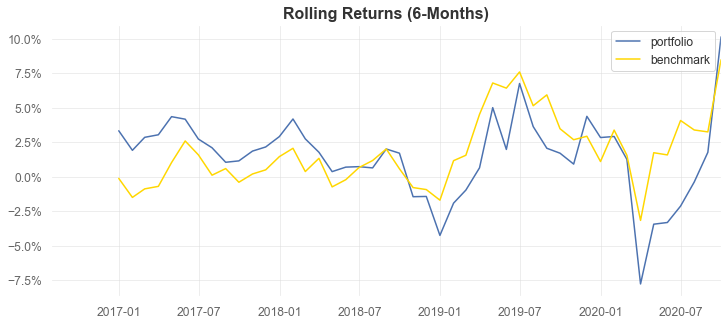

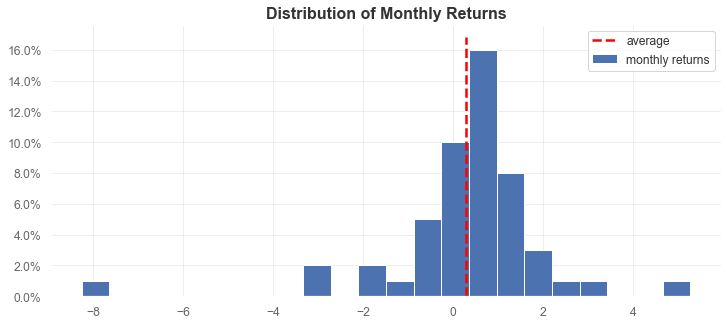

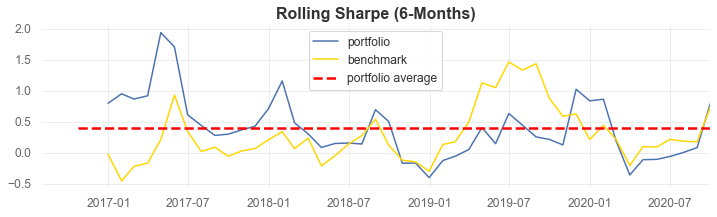

In [747]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Cumulative Returns
p_tot_rets = (monthly_returns['return'] + 1).cumprod() - 1
b_tot_rets = (bogey['return'] + 1).cumprod() - 1

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(p_tot_rets * 100)
ax.plot(b_tot_rets * 100, 'gold')
ax.legend(['portfolio', 'benchmark'])
ax.set_title('Cumulative Returns vs Benchmark', fontdict={'fontweight': 'bold', 'fontsize': 16})
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(True)
ax.set_xlim((p_tot_rets.index[0], p_tot_rets.index[-1]))
plt.show()

# Underwater Plot
p_under = - ((p_tot_rets + 1).expanding().max() / (p_tot_rets + 1) - 1) * 100
fig, ax = plt.subplots(figsize=(12,2))
ax.plot(p_under, 'fuchsia')
xmin, xmax = ax.get_xlim()
ax.fill_between(p_under.index, p_under, [0] * len(p_under),  color='fuchsia', alpha=0.3)
ax.set_title('Equity Underwater', fontdict={'fontweight': 'bold', 'fontsize': 16})
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(True)
plt.show()

# Monthly Returns
fig, ax = plt.subplots(figsize=(12,2))
ax.plot(monthly_returns['return'] * 100, 'royalblue')
ax.set_title('Monthly Returns', fontdict={'fontweight': 'bold', 'fontsize': 16})
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(True)
plt.show()

# Rolling 6 Month Volatility, Annualized
p_roll_vol = monthly_returns['return'].rolling(window=6, min_periods=6).std() * 100 * np.sqrt(2)
b_roll_vol = bogey['return'].rolling(window=6, min_periods=6).std() * 100 * np.sqrt(2)
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(p_roll_vol)
ax.plot(b_roll_vol, 'gold')
xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], [np.mean(p_roll_vol)] * 2, 'red', linewidth=2.5, linestyle='--')
ax.legend(['portfolio', 'benchmark', 'portfolio average'])
ax.set_title('Rolling Volatility (6-Months)', fontdict={'fontweight': 'bold', 'fontsize': 16})
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(True)
ax.set_xlim((p_roll_rets.index[0], p_roll_rets.index[-1]))
plt.show()

# Rolling 6 Month Returns
p_roll_rets = (monthly_returns['return'] + 1).rolling(window=6, min_periods=6).apply(lambda x: x.prod() - 1)
b_roll_rets = (bogey['return'] + 1).rolling(window=6, min_periods=6).apply(lambda x: x.prod() - 1)
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(p_roll_rets * 100)
ax.plot(b_roll_rets * 100, 'gold')
ax.legend(['portfolio', 'benchmark'])
ax.set_title('Rolling Returns (6-Months)', fontdict={'fontweight': 'bold', 'fontsize': 16})
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(True)
ax.set_xlim((p_roll_rets.index[0], p_roll_rets.index[-1]))
plt.show()

# Distribution of monthly returns
avg_ret = np.mean(p_rets) * 100
fig, ax = plt.subplots(figsize=(12,5))
bin_heights, bin_borders, _ = plt.hist(p_rets * 100, bins='auto', label='histogram')
ymin, ymax = ax.get_ylim()
ax.plot([avg_ret, avg_ret], [ymin, ymax], 'red', linewidth=2.5, linestyle='--')
ax.legend(['average', 'monthly returns'])
ax.set_title('Distribution of Monthly Returns', fontdict={'fontweight': 'bold', 'fontsize': 16})
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(True)
plt.show()

# Rolling 6 Month Sharpe Ratio
p_roll_sharpe = (monthly_returns['return']).rolling(window=6, min_periods=6).apply(lambda x: x.mean() / x.std())
b_roll_sharpe = (bogey['return']).rolling(window=6, min_periods=6).apply(lambda x: x.mean() / x.std())
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(p_roll_sharpe)
ax.plot(b_roll_sharpe, 'gold')
xmin, xmax = ax.get_xlim()
ax.set_xlim((p_roll_rets.index[0], p_roll_rets.index[-1]))
ax.plot([xmin, xmax], [np.mean(p_roll_sharpe)] * 2, 'red', linewidth=2.5, linestyle='--')
ax.legend(['portfolio', 'benchmark', 'portfolio average'])
ax.set_title('Rolling Sharpe (6-Months)', fontdict={'fontweight': 'bold', 'fontsize': 16})
ax.grid(True)
plt.show()

In [831]:
from dateutil.relativedelta import relativedelta
from scipy.stats import skew
from scipy.stats import kurtosis
import yfinance as yf
import statsmodels.api as sm

# Total Return
n_years = relativedelta(p_tot_rets.index[-1], p_tot_rets.index[0]).years

# Download market proxy from yahoo finance
market = yf.Ticker('^W5000')
hist = market.history(period='max')['Close']
hist = hist.resample('M').last()
hist = hist.pct_change()
hist = hist[(hist.index >= p_tot_rets.index[0]) & (hist.index <= p_tot_rets.index[-1])]

# Downlaod 10-year for FRED
url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?&id=DGS10&nd=1962-01-02'
tbill = pd.read_csv(url, parse_dates=[0], index_col=[0])
tbill[tbill['DGS10'] == '.'] = np.nan
tbill['DGS10'] = tbill['DGS10'].astype(float)
tbill = tbill.fillna(method='ffill')
tbill = tbill.resample('M').last()
tbill = tbill[(tbill.index >= p_tot_rets.index[0]) & (tbill.index <= p_tot_rets.index[-1])]
tbill = tbill / 100

# Portfolio Beta
Y = monthly_returns['return']
X = hist
X = sm.add_constant(X)
model = sm.OLS(Y,X)
res = model.fit()
portfolio_beta = res.params.loc['Close']

# Bogey Beta
Y = bogey['return']
X = hist
X = sm.add_constant(X)
model = sm.OLS(Y,X)
res = model.fit()
bogey_beta = res.params.loc['Close']

# Jensens
ann_port_rets = np.mean(np.power(monthly_returns['return'] + 1, 12) - 1)
ann_bogey_rets = np.mean(np.power(bogey['return'] + 1, 12) - 1) 
portfolio_alpha = np.mean(tbill.values) + portfolio_beta * (np.mean(hist.values) - np.mean(tbill.values))
bogey_alpha = np.mean(tbill.values) + bogey_beta * (np.mean(hist.values) - np.mean(tbill.values))


results = {
    'Total Return': [p_tot_rets[-1], b_tot_rets[-1]],
    'CAGR': [(np.power(p_tot_rets[-1] + 1, 1 / n_years) - 1), 
             (np.power(b_tot_rets[-1] + 1, 1 / n_years) - 1)],
    'Sharpe': [np.mean(monthly_returns['return']) / np.std(monthly_returns['return']), 
               np.mean(bogey['return']) / np.std(bogey['return'])],
    'Sortino': [np.mean(monthly_returns['return']) / np.std(monthly_returns[monthly_returns['return'] < 0]['return']), 
                np.mean(bogey['return']) / np.std(bogey[bogey['return'] < 0]['return'])],
    'MaxDD': [np.min(p_under)/ 100, 
              -np.max((b_tot_rets + 1).expanding().max() / (b_tot_rets + 1) - 1)],
    'Volatility': [np.std(monthly_returns['return']) * np.sqrt(12), 
                   np.std(bogey['return']) * np.sqrt(12)],
    'R2': [np.corrcoef(monthly_returns['return'], bogey['return'])[0, 1], 
           np.corrcoef(monthly_returns['return'], bogey['return'])[0, 1]],
    'Skew': [skew(monthly_returns['return']), skew(bogey['return'])],
    'Kurtosis': [kurtosis(monthly_returns['return']), kurtosis(bogey['return'])],
    'E(Return, Monthly)': [np.mean(monthly_returns['return']), np.mean(bogey['return'])],
    'E(Return, Annual)': [np.mean((monthly_returns['return'] + 1).rolling(window=12, min_periods=12).apply(lambda x: x.prod() - 1)),
                          np.mean((bogey['return'] + 1).rolling(window=12, min_periods=12).apply(lambda x: x.prod() - 1))],
    '1M': [monthly_returns['return'].values[-1], bogey['return'].values[-1]],
    '3M': [(monthly_returns['return'] + 1).rolling(window=3, min_periods=3).apply(lambda x: x.prod() - 1).values[-1], 
           (bogey['return'] + 1).rolling(window=3, min_periods=3).apply(lambda x: x.prod() - 1).values[-1]],
    '6M': [(monthly_returns['return'] + 1).rolling(window=6, min_periods=6).apply(lambda x: x.prod() - 1).values[-1], 
           (bogey['return'] + 1).rolling(window=6, min_periods=6).apply(lambda x: x.prod() - 1).values[-1]],
    '1Y': [(monthly_returns['return'] + 1).rolling(window=12, min_periods=12).apply(lambda x: x.prod() - 1).values[-1], 
           (bogey['return'] + 1).rolling(window=12, min_periods=12).apply(lambda x: x.prod() - 1).values[-1]],
    '3Y': [(monthly_returns['return'] + 1).rolling(window=36, min_periods=36).apply(lambda x: x.prod() - 1).values[-1], 
           (bogey['return'] + 1).rolling(window=36, min_periods=36).apply(lambda x: x.prod() - 1).values[-1]],
    '5Y': [(monthly_returns['return'] + 1).rolling(window=60, min_periods=60).apply(lambda x: x.prod() - 1).values[-1], 
           (bogey['return'] + 1).rolling(window=60, min_periods=60).apply(lambda x: x.prod() - 1).values[-1]],
    '10Y': [(monthly_returns['return'] + 1).rolling(window=120, min_periods=120).apply(lambda x: x.prod() - 1).values[-1], 
           (bogey['return'] + 1).rolling(window=120, min_periods=120).apply(lambda x: x.prod() - 1).values[-1]],
    'Beta': [portfolio_beta, bogey_beta],
    'Jensen Alpha': [portfolio_alpha, bogey_alpha],
}

# Formatting
results = pd.DataFrame.from_dict(results, orient='index')
results.columns = ['Portfolio', 'Benchmark']
pct_labels = ['Total Return', 'CAGR', 'MaxDD', 'E(Return, Monthly)', 'E(Return, Annual)', '1M', '3M', '6M', '1Y', '3Y', '5Y', '10Y']
results.loc[pct_labels, :] = results.loc[pct_labels, :] * 100
results = results.apply(np.round, args=(2,))
results = results.astype(str)
results[results == 'nan'] = ''
results.loc[pct_labels, :] = results.loc[pct_labels, :] + '%'
results

,Portfolio,Benchmark
Total Return,15.01%,16.47%
CAGR,3.56%,3.89%
Sharpe,0.16,0.23
Sortino,0.14,0.3
MaxDD,-11.13%,-5.62%
Volatility,0.06,0.05
R2,0.8,0.8
Skew,-1.85,-0.42
Kurtosis,9.06,4.38
"E(Return, Monthly)",0.29%,0.31%
